In [226]:
%matplotlib inline

from __future__ import division
from collections import defaultdict
import sqlite3
from datetime import datetime, date, time
import math
import numpy as np
import matplotlib.pylab
import pandas as pd
import pymc3
import seaborn as sns
sns.set(palette="Set2")

In [227]:
sqlite_file = '/Users/chriswright/invite_dataset_ff829852.sqlite'
conn = sqlite3.connect(sqlite_file)
cursor = conn.cursor()

cursor.execute('''SELECT invites.sent_time,quotes.sent_time FROM invites LEFT OUTER JOIN quotes ON invites.invite_id=quotes.invite_id''')
events = cursor.fetchall()
conn.commit()
conn.close()

In [142]:
import statsmodels.api as sm
df = pd.DataFrame(events)
df.columns = ['invite_st','quote_st','category','location']
df['y'] = df['quote_st'].apply(lambda x: 1.0 if x else 0.0)
df_cat = pd.get_dummies(df['category'])
df_loc = pd.get_dummies(df['location'])
dummy_features = df_cat.join(df_loc)
data = df.join(dummy_features)
data.drop(['invite_st','quote_st','category','location'],inplace=True,axis=1)
data['intercept']=1.0
train_cols = data.columns[1:]
data.info()
logit = sm.Logit(data['y'], data[train_cols])
result = logit.fit()
print result.summary()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24664 entries, 0 to 24663
Columns: 215 entries, y to intercept
dtypes: float64(215)
memory usage: 40.6 MB
         Current function value: 0.601366
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                24664
Model:                          Logit   Df Residuals:                    24452
Method:                           MLE   Df Model:                          211
Date:                Wed, 15 Jul 2015   Pseudo R-squ.:                  0.1314
Time:                        11:49:38   Log-Likelihood:                -14832.
converged:                      False   LL-Null:                       -17077.
                                        LLR p-value:                     0.000
                                                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------

/Library/Python/2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [233]:
def invite_to_quote_calculator(events):
    d = defaultdict(list)
    for event in events:
        dt = datetime.strptime(event[0], "%Y-%m-%d %H:%M:%S.%f")
        pdt = dt.strftime("%Y-%m-%d")
        if event[1]:
            d[pdt].append(1)
        else:
            d[pdt].append(0)
    return d
            
records = invite_to_quote_calculator(events)

daily_signal = []

for k,v in records.items():
    daily_signal.append(np.mean(v))
    print k, np.mean(v), np.std(v)

2013-08-26 0.558044806517 0.496619371789
2013-08-27 0.497854077253 0.499995394994
2013-08-28 0.534246575342 0.498825793316
2013-08-19 0.557303370787 0.496705469767
2013-08-18 0.492805755396 0.499948240165
2013-08-31 0.532258064516 0.498958332202
2013-08-30 0.520661157025 0.499572934205
2013-08-15 0.441102756892 0.496518997375
2013-08-14 0.540838852097 0.498329397246
2013-08-17 0.511945392491 0.499857287231
2013-08-16 0.558404558405 0.496577191943
2013-08-11 0.608163265306 0.488160535109
2013-08-10 0.605863192182 0.488664490771
2013-08-13 0.52380952381 0.499432784843
2013-08-12 0.492631578947 0.499945703423
2013-07-09 0.471887550201 0.499209064587
2013-07-08 0.547826086957 0.497707409435
2013-07-03 0.492027334852 0.49993643257
2013-07-02 0.456310679612 0.498087585957
2013-07-01 0.468493150685 0.499006331068
2013-07-07 0.485893416928 0.499800964699
2013-07-06 0.48253968254 0.499695044316
2013-07-05 0.464 0.498702316016
2013-07-04 0.486910994764 0.499828648581
2013-07-21 0.46644295302 0.4

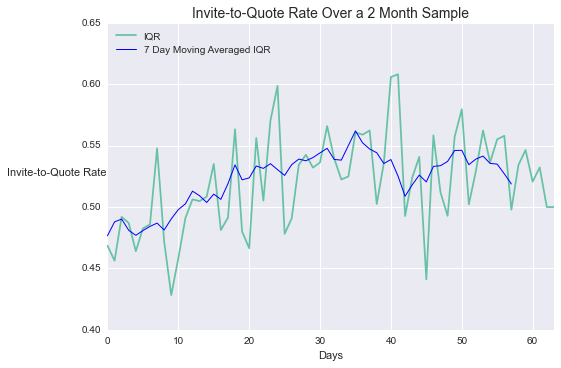

In [58]:
def moving_average(values, window):
    weights = np.repeat(1.0, window)/window
    sma = np.convolve(values, weights, 'valid')
    return sma

rate = []
for k,v in records.items():
    rate.append([k, np.mean(v)])
sorted_rate = sorted(rate, key=lambda x: x[0])
dates = pd.to_datetime([rec[0] for rec in sorted_rate])
values = np.array([rec[1] for rec in sorted_rate])
plot_data = pd.Series(values, index=dates)
ax = sns.tsplot(data=plot_data, condition='IQR')
ma = plt.plot(moving_average(plot_data, 7), color='blue',linewidth=1, label='7 Day Moving Averaged IQR')
plt.title("Invite-to-Quote Rate Over a 2 Month Sample", fontsize=14)
plt.xlabel("Days")
plt.ylabel("Invite-to-Quote Rate", rotation=0, labelpad=25)
plt.legend(loc='upper left')

In [184]:
ts.adfuller(plot_data, 1)
ts.adfuller(plot_data, regression="ct")[:2]
ts.adfuller(np.diff(plot_data), regression="c")[:2]

(-6.0977843445988151, 1.0003551824087032e-07)